Reusing code from https://www.kaggle.com/code/agggshambhavi/pytorch-brain-mri-binary-segmentation

# Imports

In [1]:
!pip install opencv-python-headless sklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 MB 22.1 MB/s eta 0:00:0000:0100:01
  Using cached sklearn-0.0-py2.py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 29.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 25.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 8.7 MB/s eta 0:00:00
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)


In [3]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 23.1 MB/s eta 0:00:0000:0100:01


In [5]:
import os

import numpy as np
import pandas as pd

from PIL import Image
import cv2

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Defining parameters

In [6]:
data_dir = "kaggle_3m/"

train_fraction = 0.8
validation_fraction = 0.2
batch_size = 16

input_dim = 256
input_ch = 3
output_dim = 256
output_ch = 1

learning_rate = 0.01
epochs = 25
SEED1 = 1
SEED2 = 2

# Reading images path

In [7]:
dirs, images, masks = [], [], []

for root, folders, files in  os.walk(data_dir):
    for file in files:
        if 'mask' in file:
            dirs.append(root.replace(data_dir, ''))
            masks.append(file)
            images.append(file.replace("_mask", ""))

PathDF = pd.DataFrame({'directory': dirs,
                      'images': images,
                      'masks': masks})
PathDF.head()

,directory,images,masks
0,TCGA_CS_6667_20011105,TCGA_CS_6667_20011105_8.tif,TCGA_CS_6667_20011105_8_mask.tif
1,TCGA_CS_6667_20011105,TCGA_CS_6667_20011105_9.tif,TCGA_CS_6667_20011105_9_mask.tif
2,TCGA_CS_6667_20011105,TCGA_CS_6667_20011105_2.tif,TCGA_CS_6667_20011105_2_mask.tif
3,TCGA_CS_6667_20011105,TCGA_CS_6667_20011105_3.tif,TCGA_CS_6667_20011105_3_mask.tif
4,TCGA_CS_6667_20011105,TCGA_CS_6667_20011105_20.tif,TCGA_CS_6667_20011105_20_mask.tif


In [8]:
for i in PathDF.index:
    PathDF.loc[i, "diagnosis"] = 1 if np.max(cv2.imread(os.path.join(data_dir, PathDF.loc[i, 'directory'], PathDF.loc[i,"masks"]))) > 0 else 0

In [9]:
PathDF.head()

,directory,images,masks,diagnosis
0,TCGA_CS_6667_20011105,TCGA_CS_6667_20011105_8.tif,TCGA_CS_6667_20011105_8_mask.tif,0.0
1,TCGA_CS_6667_20011105,TCGA_CS_6667_20011105_9.tif,TCGA_CS_6667_20011105_9_mask.tif,0.0
2,TCGA_CS_6667_20011105,TCGA_CS_6667_20011105_2.tif,TCGA_CS_6667_20011105_2_mask.tif,0.0
3,TCGA_CS_6667_20011105,TCGA_CS_6667_20011105_3.tif,TCGA_CS_6667_20011105_3_mask.tif,0.0
4,TCGA_CS_6667_20011105,TCGA_CS_6667_20011105_20.tif,TCGA_CS_6667_20011105_20_mask.tif,0.0


In [10]:
train_df, valid_df = train_test_split(PathDF, random_state=SEED1,
                                 test_size = validation_fraction)

print('Train:', train_df.shape[0])
print('Valid:', valid_df.shape[0])

train_df2, valid_df2 = train_test_split(PathDF, random_state=SEED2,
                                 test_size = validation_fraction)

print('Train2:', train_df2.shape[0])
print('Valid2:', valid_df2.shape[0])

Train: 3143
Valid: 786
Train2: 3143
Valid2: 786


In [11]:
train_df

,directory,images,masks,diagnosis
1544,TCGA_FG_5962_20000626,TCGA_FG_5962_20000626_42.tif,TCGA_FG_5962_20000626_42_mask.tif,1.0
2433,TCGA_DU_5854_19951104,TCGA_DU_5854_19951104_14.tif,TCGA_DU_5854_19951104_14_mask.tif,0.0
3473,TCGA_CS_6668_20011025,TCGA_CS_6668_20011025_11.tif,TCGA_CS_6668_20011025_11_mask.tif,0.0
3710,TCGA_EZ_7264_20010816,TCGA_EZ_7264_20010816_20.tif,TCGA_EZ_7264_20010816_20_mask.tif,1.0
195,TCGA_DU_7010_19860307,TCGA_DU_7010_19860307_33.tif,TCGA_DU_7010_19860307_33_mask.tif,1.0
...,...,...,...,...
905,TCGA_HT_7608_19940304,TCGA_HT_7608_19940304_2.tif,TCGA_HT_7608_19940304_2_mask.tif,0.0
3839,TCGA_HT_7881_19981015,TCGA_HT_7881_19981015_37.tif,TCGA_HT_7881_19981015_37_mask.tif,1.0
1096,TCGA_FG_6689_20020326,TCGA_FG_6689_20020326_1.tif,TCGA_FG_6689_20020326_1_mask.tif,0.0
235,TCGA_FG_6688_20020215,TCGA_FG_6688_20020215_34.tif,TCGA_FG_6688_20020215_34_mask.tif,0.0


In [12]:
train_df2

,directory,images,masks,diagnosis
3172,TCGA_DU_5852_19950709,TCGA_DU_5852_19950709_4.tif,TCGA_DU_5852_19950709_4_mask.tif,0.0
1379,TCGA_DU_A5TT_19980318,TCGA_DU_A5TT_19980318_37.tif,TCGA_DU_A5TT_19980318_37_mask.tif,0.0
2242,TCGA_FG_6691_20020405,TCGA_FG_6691_20020405_37.tif,TCGA_FG_6691_20020405_37_mask.tif,0.0
1685,TCGA_FG_6690_20020226,TCGA_FG_6690_20020226_31.tif,TCGA_FG_6690_20020226_31_mask.tif,1.0
2934,TCGA_HT_8106_19970727,TCGA_HT_8106_19970727_10.tif,TCGA_HT_8106_19970727_10_mask.tif,1.0
...,...,...,...,...
3606,TCGA_DU_6407_19860514,TCGA_DU_6407_19860514_40.tif,TCGA_DU_6407_19860514_40_mask.tif,0.0
1608,TCGA_CS_5396_20010302,TCGA_CS_5396_20010302_14.tif,TCGA_CS_5396_20010302_14_mask.tif,1.0
2541,TCGA_HT_7856_19950831,TCGA_HT_7856_19950831_3.tif,TCGA_HT_7856_19950831_3_mask.tif,0.0
2575,TCGA_CS_5393_19990606,TCGA_CS_5393_19990606_16.tif,TCGA_CS_5393_19990606_16_mask.tif,0.0


# Creating Torch Datasets and DataLoaders

In [13]:
class MRI_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform
        
    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        
        base_path = os.path.join(data_dir, self.path_df.iloc[idx]['directory'])
        img_path = os.path.join(base_path, self.path_df.iloc[idx]['images'])
        mask_path = os.path.join(base_path, self.path_df.iloc[idx]['masks'])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        sample = (image, mask)
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample            

Preprocessing function to apply to images

In [14]:
class PairedToTensor():
    def __call__(self, sample):
        img, mask = sample
        img = np.array(img)
        mask = np.expand_dims(mask, -1)
        img = np.moveaxis(img, -1, 0)
        mask = np.moveaxis(mask, -1, 0)
        img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
        img = img/255
        mask = mask/255
        return img, mask

In [15]:
dataset = MRI_Dataset(train_df)
sample = dataset[13]

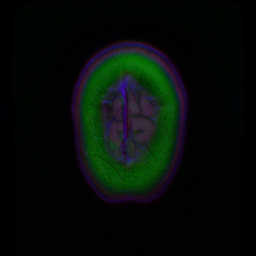

In [16]:
sample[0]

In [17]:
train_data = MRI_Dataset(train_df, transform=PairedToTensor())
valid_data = MRI_Dataset(valid_df, transform=PairedToTensor())

train_loader = DataLoader(train_data, batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size,
                         shuffle=False)

# Loading pretrained model

In [19]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /Users/j9s/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


# Defining utility functions

Custom metrics

In [20]:
# code taken from https://www.kaggle.com/code/lqdisme/brain-mri-segmentation-unet-pytorch/notebook
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union

In [21]:
def iou(pred, label):
    intersection = (pred * label).sum()
    union = pred.sum() + label.sum() - intersection
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union

Training loop

In [22]:
def train_loop(model, optimizer, criterion, train_loader):
    running_loss = 0
    model.train()
    
    final_dice_coef = 0 

    for i, data in enumerate(train_loader, 0):
        imgs, masks = data

        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item() * imgs.shape[0]
        
        out_cut = np.copy(out.detach().cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
        train_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
        final_dice_coef += train_dice 
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    running_loss /= len(train_loader.sampler)
    return {'dice coef':final_dice_coef/len(train_loader), 
                'loss':running_loss}

Validation loop

In [23]:
def eval_loop(model, criterion, eval_loader):
    
    running_loss = 0
    final_dice_coef = 0 
    
    model.eval()
    with torch.no_grad():

        for i, data in enumerate(eval_loader, 0):
            
            imgs, masks = data
            
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item() * imgs.shape[0]
            
            out_cut = np.copy(out.detach().cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            valid_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
            final_dice_coef += valid_dice 
            
    running_loss /= len(eval_loader.sampler)   
    return {
                'dice coef':final_dice_coef/len(eval_loader), 
                'loss':running_loss}

General training function

In [24]:
def train(model, optimizer, criterion, scheduler, train_loader, valid_loader,
          num_epochs = epochs,
          valid_loss_min = np.inf):
    
    train_loss_list = []
    train_dice_coef = []
    val_loss_list = []
    val_dice_coef = []
    
    for e in range(num_epochs):
        
        train_metrics = train_loop(model, optimizer, criterion, 
                                   train_loader)
        
        val_metrics = eval_loop(model, criterion, valid_loader)
        
        scheduler.step(val_metrics['dice coef'])
        
        train_loss_list.append(train_metrics['loss']) 
        train_dice_coef.append(train_metrics['dice coef'])
        val_loss_list.append(val_metrics['loss'])
        val_dice_coef.append(val_metrics['dice coef'])
        
        print_string = f"Epoch: {e+1}\n"
        print_string += f"Train Loss: {train_metrics['loss']:.5f}\n"
        print_string += f"Train Dice Coef: {train_metrics['dice coef']:.5f}\n"
        print_string += f"Valid Loss: {val_metrics['loss']:.5f}\n"
        print_string += f"Valid Dice Coef: {val_metrics['dice coef']:.5f}\n"
        print(print_string)
        
        # save model
        #if val_metrics["loss"] <= valid_loss_min:
        #    torch.save(model.state_dict(), "UNET.pt")
        #    valid_loss_min = val_metrics["loss"]
        
    return [train_loss_list,
    train_dice_coef,
    val_loss_list,
    val_dice_coef]

# Train model

In [25]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
criterion = nn.BCELoss(reduction='mean')
# Only 1 epoch, just to make sure the code is running - can take a while with CPU only
train_loss_list, train_dice_coef,val_loss_list,val_dice_coef = train(
    model, optimizer, criterion, scheduler, train_loader, valid_loader, num_epochs=1)

/var/folders/s0/plfdbhwn6ss5q5b3mx8cw_5c0000gn/T/ipykernel_15053/3255609807.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:178.)
  img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)


Epoch: 1
Train Loss: 0.03227
Train Dice Coef: 0.37651
Valid Loss: 0.03971
Valid Dice Coef: 0.10446

